In [11]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 
import time

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#distance Libaray
from dtw import *
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.spatial.distance import cityblock

#RNN Libarary
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [12]:
# Đọc Dữ Liệu
# @param   filePath     Đường dẫn tập dữ liệu CSV
# @return  df           Tập dữ liệu csv dưới dạng df
def readData(filePath):
    # Load dữ liệu
    dataCSV = pd.read_csv(filePath)
    df=dataCSV[['GLD']]
    return df

# Tiền Xử lý Dữ Liệu
# @param  Data   Tập dữ liệu
# @return df     Dữ liệu đã được tiền xử lý
def cleanData(df):
    # Replace null values with 0
    df.fillna(0, inplace=True)
    # Remove outliers by replacing values outside of 10 standard deviations with the mean
    # std = df['GLD'].std()
    # mean = df['GLD'].mean()
    # df['GLD'] = np.where(df['GLD'] > (mean + 10*std), mean, df['GLD'])
    # df['GLD'] = np.where(df['GLD'] < (mean - 10*std), mean, df['GLD'])
    # Scale data_AMZN to range [0, 1]
    scaler = MinMaxScaler()
    df['GLD'] = scaler.fit_transform(df['GLD'].values.reshape(-1, 1))
    # Fill in missing values with the mean of the previous and next values
    df['GLD'] = df['GLD'].interpolate(method='linear')
    return df

# Chia dữ liệu thành train set và test set
# @param  data                      Tập dữ liệu
# @param  percentTrain              Tỷ lệ Tập train
# @return train_data, test_data     Tập train và test   
def splitData(data, percentTrain):
    train_size = int(len(data) * (percentTrain/100))
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    return train, test

# Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
# @param      data            Dữ liệu cần chia cửa sổ
# @param      size_window     Kích thước cửa sổ
# @param      size_predict    Kích thước cửa sổ dự đoán
# @param      stepWindow      số điểm dữ liệu trượt
# @return     X, y            mảng cửa sổ mẫu và mảng điểm dự đoán tương ứng
def prepare_data(data, size_window, size_predict, stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        startWindow += stepWindow
    return np.array(X), np.array(y)

#---------KNN-----------
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean    
def euclidean_distance(ts1, ts2):
    ts1= ts1.flatten()
    ts2= ts2.flatten()
    return euclidean(ts1,ts2)

# Function lấy ra k chuỗi gần nhất
# @param    k             Số lượng chuỗi gần nhất
# @param    distanceArr   Mảng khoảng cách
# @return   argsort       Vị trí chuỗi gần nhất        
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

# Tính khoảng cách DTW
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean  
def dtw_dist(ts1, ts2):
    dist, _ = fastdtw(ts1, ts2, dist=cityblock)
    return dist

# Thêm Dữ liệu
# @param    X_train               Cửa sổ mẫu train
# @param    y_train               Cửa sổ dự đoán train
# @param    XTest                 Cửa sổ mẫu test
# @param    yTest                 Cửa sổ dự đoán test
# @return   X_train, y_train      Khoảng cách euclidean 
def toTrain(X_train, y_train, XTest, yTest):
    X_train.append(XTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

# Dự đoán Euclidean
# @param    nameData           Tên tập dữ liệu
# @param    k                  Số lượng chuỗi gần nhất
# @param    typeDistance       Độ đo sử dụng (Dtw, euclidean)
# @param    X_train            Cửa sổ mẫu train
# @param    y_train            Cửa sổ dự đoán train
# @param    X_test             Cửa sổ mẫu test
# @param    y_test             Cửa sổ dự đoán test
# @return   y_pred_arr         Mảng dự đoán
def predict_KNN(k, typeDistance, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            if(typeDistance == 'Dtw'):
                distance = dtw_dist(X_test[iTest],X_train[iTrain])
            else:
                distance = euclidean_distance(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)
        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = toTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        y_pred = np.array(y_pred_arr)
   
    return y_pred


#----------------FFNN--------------------------
# Khởi tạo mô hình FFNN
# @param    neuralInput         Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    num_layers_hidden   Số lượng lớp ẩn
# @param    num_neural_hidden   Số neural lớp ẩn
# @param    neuralOutput         Số neural lớp ouput
# @return   model               Mô hình FFNN
def create_model_FFNN(neuralInput, num_layers_hidden=1, neuralHidden=1, neuralOutput=1):
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(Dense(neuralHidden, input_dim= neuralInput, activation='sigmoid'))
        else:
            model.add(Dense(neuralHidden, activation='sigmoid'))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_FFNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': [8, 16, 32, 64, 128],
              'epochs': [50, 100, 150, 200, 250, 300],
              'neuralHidden': [neuralHidden],
              'num_layers_hidden' : [numHiddenLayer],
              'neuralInput' : [size_window],
              'neuralOutput' : [size_predict]}

    # create the model
    model_FFNN = KerasRegressor(build_fn=create_model_FFNN, verbose=0)
    
    # perform the grid search
    grid_FFNN = GridSearchCV(estimator=model_FFNN, param_grid=param_grid_FFNN, cv=3)
    grid_result_FFNN = grid_FFNN.fit(X_train, y_train)
    
    # train the model with the best parameters
    best_params_FFNN = grid_result_FFNN.best_params_
    
    model_FFNN = create_model_FFNN( best_params_FFNN['neuralInput'], best_params_FFNN['num_layers_hidden'], best_params_FFNN['neuralHidden'],best_params_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=best_params_FFNN['epochs'], batch_size=best_params_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    return best_params_FFNN



# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    batchSize         Số lượng mẫu được đưa vào với mỗi lần lặp (epoch)
# @param    epoch             Số lần lặp cập nhật trọng số
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_best_param_FFNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': batchSize,
              'epochs': epoch,
              'neuralHidden': neuralHidden,
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
    
    model_FFNN = create_model_FFNN( param_grid_FFNN['neuralInput'], param_grid_FFNN['num_layers_hidden'], param_grid_FFNN['neuralHidden'],param_grid_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=param_grid_FFNN['epochs'], batch_size=param_grid_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN.save_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
   
    return param_grid_FFNN

# Dự Đoán FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    typePredict       Thực hiện loại dự đoán (FFNN_Find_NeuralHidden,FFNN_Find_NumberHiddenLayer,CombinePredict)
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    X_test            Cửa sổ dự đoán tập train
# @param    best_params_FFNN  Cửa sổ dự đoán tập train
# @return   predictions_FFNN  Mảng dự đoán
def predict_FFNN(nameData, typePredict, X_train, y_train, X_test, best_params_FFNN):
    model_FFNN1 = Sequential()
    for i in range(best_params_FFNN['num_layers_hidden']):
        if i == 0:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], input_dim= best_params_FFNN['neuralInput'], activation='sigmoid'))
        else:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], activation='sigmoid'))
    model_FFNN1.add(Dense(best_params_FFNN['neuralOutput']))
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN1.load_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
    else:
        model_FFNN1.load_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.weights.h5')   
   
    model_FFNN1.compile(loss='mean_squared_error', optimizer='adam')
    
    predictions_FFNN = model_FFNN1.predict(X_test)
    return predictions_FFNN

#---------------------Song Song------------------------------#

# Lai Ghép Song Song
# @param    y_pred_FFNN     Mảng dự đoán của FFNN
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   y_pred_combine  Mảng dự đoán kết hợp
def predictHybrid(y_pred_FFNN,y_pred_KNN,y_test):
    FFNNSubKNN=[]
    TestSubKNN=[]
    weightEl=[]
    for i in range(len(y_pred_FFNN)):
        FFNNSubKNN.append(y_pred_FFNN[i]-y_pred_KNN[i])
        TestSubKNN.append(y_test[i]-y_pred_KNN[i])

    for j in range(len(FFNNSubKNN)):
        weightEl.append(((FFNNSubKNN[j]*TestSubKNN[j])/ (FFNNSubKNN[j]*FFNNSubKNN[j])))
    
    weight = np.array(weightEl)
    
    y_pred_combine=[]
    for i in range(len(weight)):
        y_pred_combine.append(weight[i]*y_pred_FFNN[i]+(1-weight[i])*y_pred_KNN[i])
    y_pred_combine=np.array(y_pred_combine)
    return y_pred_combine

#---------------------Tuần Tự------------------------------#

# Tính Lỗi Theo Từng Ngày
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   mseWithDay     Mảng lỗi theo ngày
def mseWithDay(y_pred_KNN, y_test):
    mseDay = []
    for i in range(len(y_pred_KNN)):
        mseDay.append([abs((y_test[i] - y_pred_KNN[i]))])
    mseDay=np.array(mseDay)
    return mseDay

def predictSum(y_pred_mse,y_pred_KNN):
    pred_knn_ffnn=[]
    for i in range(len(y_pred_mse)):
        pred_knn_ffnn.append(y_pred_KNN[i]+y_pred_mse[i])
    pred_knn_ffnn=np.array(pred_knn_ffnn)
    return pred_knn_ffnn

#----------------RNN--------------------------
def create_model_RNN(neuralInput, num_layers_hidden=1, neuralHidden=50, neuralOutput=1, activation='tanh', optimizer='adam'):
    """
    Creates a Sequential RNN model.

    Parameters:
    - neuralInput (int): Number of input features.
    - num_layers_hidden (int): Number of recurrent hidden layers.
    - neuralHidden (int): Number of neurons in each hidden layer.
    - neuralOutput (int): Number of output neurons.
    - activation (str): Activation function for hidden layers.
    - optimizer (str): Optimizer for compiling the model.

    Returns:
    - model (Sequential): Compiled RNN model.
    """
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(SimpleRNN(neuralHidden, activation=activation, return_sequences=(i < num_layers_hidden - 1), input_shape=(neuralInput, 1)))
        else:
            model.add(SimpleRNN(neuralHidden, activation=activation, return_sequences=(i < num_layers_hidden - 1)))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Train RNN with Grid Search
def train_RNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden=50, numHiddenLayer=1, size_predict=1):
    """
    Trains an RNN model using GridSearchCV to find the best hyperparameters.

    Parameters:
    - nameData (str): Name of the dataset.
    - typePredict (str): Type of prediction task.
    - size_window (int): Size of the input window.
    - X_train (array): Training input data.
    - y_train (array): Training target data.
    - neuralHidden (int): Number of neurons in hidden layers.
    - numHiddenLayer (int): Number of hidden layers.
    - size_predict (int): Size of the prediction window.

    Returns:
    - best_params_RNN (dict): Best hyperparameters found.
    """
    # Reshape input data to [samples, timesteps, features]
    X_train_reshaped = X_train.reshape((X_train.shape[0], size_window, 1))

    # Define parameter grid
    param_grid_RNN = {
        'batch_size': [8, 16, 32, 64, 128],
        'epochs': [50, 100, 150, 200, 250, 300],
        'neuralHidden': [neuralHidden],
        'num_layers_hidden': [numHiddenLayer],
        'neuralInput': [size_window],
        'neuralOutput': [size_predict],
        'activation': ['tanh', 'relu'],
        'optimizer': ['adam', 'rmsprop']
    }

    # Create the KerasRegressor
    model_RNN = KerasRegressor(build_fn=create_model_RNN, verbose=0)

    # Initialize GridSearchCV
    grid_RNN = GridSearchCV(estimator=model_RNN, param_grid=param_grid_RNN, cv=3, scoring='neg_mean_squared_error')

    # Perform grid search
    grid_result_RNN = grid_RNN.fit(X_train_reshaped, y_train)

    # Get the best parameters
    best_params_RNN = grid_result_RNN.best_params_

    # Create and train the final model with best parameters
    final_model_RNN = create_model_RNN(
        neuralInput=best_params_RNN['neuralInput'],
        num_layers_hidden=best_params_RNN['num_layers_hidden'],
        neuralHidden=best_params_RNN['neuralHidden'],
        neuralOutput=best_params_RNN['neuralOutput'],
        activation=best_params_RNN['activation'],
        optimizer=best_params_RNN['optimizer']
    )

    final_model_RNN.fit(
        X_train_reshaped, y_train,
        epochs=best_params_RNN['epochs'],
        batch_size=best_params_RNN['batch_size'],
        verbose=2,
        callbacks=[EarlyStopping(monitor='loss', patience=10)],
        shuffle=False
    )

    # Define the path to save weights
    save_path = f'../BestParam/RNN/{nameData}/{typePredict}/'
    os.makedirs(save_path, exist_ok=True)
    weight_filename = f"{best_params_RNN['num_layers_hidden']}_HiddenLayer_" \
                      f"{best_params_RNN['neuralHidden']}_NeuralHidden_" \
                      f"{best_params_RNN['batch_size']}_BatchSize_" \
                      f"{best_params_RNN['epochs']}_Epoch_{nameData}.weights.h5"
    final_model_RNN.save_weights(os.path.join(save_path, weight_filename))

    return best_params_RNN



# Train RNN with Specific Parameters
def train_best_param_RNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict, activation='relu', optimizer='adam'):
    # Set up parameter grid with lists
    param_grid_RNN = {
        'batch_size': [batchSize],
        'epochs': [epoch],
        'neuralHidden': [neuralHidden],
        'num_layers_hidden': [numHiddenLayer],
        'neuralInput': [size_window],
        'neuralOutput': [size_predict],
        'activation': [activation],
        'optimizer': [optimizer]
    }
    
    # Extract the best parameters directly from the dictionary
    best_params_RNN = {
        'batch_size': param_grid_RNN['batch_size'][0],
        'epochs': param_grid_RNN['epochs'][0],
        'neuralHidden': param_grid_RNN['neuralHidden'][0],
        'num_layers_hidden': param_grid_RNN['num_layers_hidden'][0],
        'neuralInput': param_grid_RNN['neuralInput'][0],
        'neuralOutput': param_grid_RNN['neuralOutput'][0],
        'activation': param_grid_RNN['activation'][0],
        'optimizer': param_grid_RNN['optimizer'][0]
    }
    
    # Create and train the RNN model
    model_RNN = create_model_RNN(
        neuralInput=best_params_RNN['neuralInput'],
        num_layers_hidden=best_params_RNN['num_layers_hidden'],
        neuralHidden=best_params_RNN['neuralHidden'],
        neuralOutput=best_params_RNN['neuralOutput'],
        activation=best_params_RNN['activation'],
        optimizer=best_params_RNN['optimizer']
    )
    
    # Train the model
    model_RNN.fit(
        X_train, y_train,
        epochs=best_params_RNN['epochs'],
        batch_size=best_params_RNN['batch_size'],
        verbose=2,
        callbacks=[EarlyStopping(monitor='loss', patience=10)],
        shuffle=False
    )

    # Save model weights based on type of prediction
    if typePredict == 'RNN_Find_NumberHiddenLayer':
        model_RNN.save_weights(f'../BestParam/RNN/{nameData}/RNN_Find_NumberHiddenLayer/{numHiddenLayer}_HiddenLayer_{neuralHidden}_NeuralHidden_{batchSize}_BatchSize_{epoch}_Epoch_{nameData}.weights.h5')
    # Add any other conditions as needed for saving

    return best_params_RNN

# Predict with the Trained RNN
def predict_RNN(nameData, typePredict, X_train, y_train, X_test, best_params_RNN):
    """
    Makes predictions using the trained RNN model.

    Parameters:
    - nameData (str): Name of the dataset.
    - typePredict (str): Type of prediction task.
    - X_train (array): Training input data.
    - y_train (array): Training target data.
    - X_test (array): Test input data.
    - best_params_RNN (dict): Best hyperparameters for the model.

    Returns:
    - predictions_RNN (array): Predicted values.
    """
    # Reshape input data to [samples, timesteps, features]
    X_test_reshaped = X_test.reshape((X_test.shape[0], best_params_RNN['neuralInput'], 1))

    # Recreate the model architecture
    model_RNN = create_model_RNN(
        neuralInput=best_params_RNN['neuralInput'],
        num_layers_hidden=best_params_RNN['num_layers_hidden'],
        neuralHidden=best_params_RNN['neuralHidden'],
        neuralOutput=best_params_RNN['neuralOutput'],
        activation=best_params_RNN['activation'],
        optimizer=best_params_RNN['optimizer']
    )

    # Define the path to load weights
    weight_filename = f"{best_params_RNN['num_layers_hidden']}_HiddenLayer_" \
                      f"{best_params_RNN['neuralHidden']}_NeuralHidden_" \
                      f"{best_params_RNN['batch_size']}_BatchSize_" \
                      f"{best_params_RNN['epochs']}_Epoch_{nameData}.weights.h5"

    weight_path = f'../BestParam/RNN/{nameData}/{typePredict}/{weight_filename}'

    if not os.path.exists(weight_path):
        raise FileNotFoundError(f"Weight file not found at {weight_path}")

    # Load the saved weights
    model_RNN.load_weights(weight_path)

    # Compile the model
    model_RNN.compile(loss='mean_squared_error', optimizer=best_params_RNN['optimizer'])

    # Make predictions
    predictions_RNN = model_RNN.predict(X_test_reshaped)

    return predictions_RNN

In [ ]:
nameData = 'GLD'
filePath = f'../data/{nameData}.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)

# Split data into training and testing sets
percentTrain = 80
train_data, test_data = splitData(timeSeries, percentTrain)

# Set window and prediction sizes
size_window = 5
size_predict = 1
stepWindow = 1

# Prepare training and testing data
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)

# Set neural network parameters
neuralHidden = 13
batchSize = 32
epoch = 200

# Initialize DataFrame to store results
df_MseWith_HiddenLayer = pd.DataFrame(columns=["Number Hidden Layer", "Neural Hidden", "Batch Size", "Epoch", "MSE", "Time Train", "Time Test", "Total Time"])

# Loop through hidden layers and train model
for numHiddenLayer in range(1, 21):
    start_train = time.time()
    
    # Train RNN model
    best_param = train_best_param_RNN(nameData, 'RNN_Find_NumberHiddenLayer', size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict)
    end_train = time.time()
    
    # Make predictions
    start_test = time.time()
    predictions_RNN = predict_RNN(nameData, 'RNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)
    end_test = time.time()
    
    # Calculate timing and performance metrics
    time_train = end_train - start_train
    time_test = end_test - start_test
    total_time = time_train + time_test
    mse = mean_squared_error(y_test, predictions_RNN)
    
    # Append results to DataFrame
    row_mse_with_hidden_layer = pd.DataFrame([[numHiddenLayer, neuralHidden, best_param['batch_size'], best_param['epochs'], mse, time_train, time_test, total_time]], 
                                             columns=df_MseWith_HiddenLayer_RNN.columns)
    df_MseWith_HiddenLayer = pd.concat([df_MseWith_HiddenLayer, row_mse_with_hidden_layer], ignore_index=True)

# Display the results
df_MseWith_HiddenLayer


Epoch 1/200
58/58 - 3s - 45ms/step - loss: 0.2333
Epoch 2/200
58/58 - 0s - 2ms/step - loss: 0.0100
Epoch 3/200
58/58 - 0s - 2ms/step - loss: 0.0059
Epoch 4/200
58/58 - 0s - 2ms/step - loss: 0.0045
Epoch 5/200
58/58 - 0s - 2ms/step - loss: 0.0037
Epoch 6/200
58/58 - 0s - 2ms/step - loss: 0.0043
Epoch 7/200
58/58 - 0s - 2ms/step - loss: 0.0030
Epoch 8/200
58/58 - 0s - 2ms/step - loss: 0.0034
Epoch 9/200
58/58 - 0s - 2ms/step - loss: 0.0029
Epoch 10/200
58/58 - 0s - 2ms/step - loss: 0.0032
Epoch 11/200
58/58 - 0s - 2ms/step - loss: 0.0029
Epoch 12/200
58/58 - 0s - 2ms/step - loss: 0.0030
Epoch 13/200
58/58 - 0s - 2ms/step - loss: 0.0029
Epoch 14/200
58/58 - 0s - 2ms/step - loss: 0.0030
Epoch 15/200
58/58 - 0s - 2ms/step - loss: 0.0030
Epoch 16/200
58/58 - 0s - 2ms/step - loss: 0.0018
Epoch 17/200
58/58 - 0s - 2ms/step - loss: 0.0021
Epoch 18/200
58/58 - 0s - 2ms/step - loss: 0.0023
Epoch 19/200
58/58 - 0s - 3ms/step - loss: 0.0015
Epoch 20/200
58/58 - 0s - 2ms/step - loss: 0.0011
Epoch 21

,Number Hidden Layer,Neural Hidden,Batch Size,Epoch,MSE,Time Train,Time Test,Total Time
0,1,13,32,200,0.001737,7.152045,0.644665,7.796710
1,2,13,32,200,0.002025,9.205762,1.505468,10.711230
2,3,13,32,200,0.002302,9.166702,1.518646,10.685348
3,4,13,32,200,0.000185,12.897301,1.575166,14.472467
4,5,13,32,200,0.019095,15.891445,2.312856,18.204301
5,6,13,32,200,0.002198,18.792742,2.976082,21.768824
6,7,13,32,200,0.007740,21.485354,2.978736,24.464090
7,8,13,32,200,0.004793,24.319909,3.953328,28.273237
8,9,13,32,200,0.004599,24.460318,3.587996,28.048314
9,10,13,32,200,0.006369,26.460353,4.162284,30.622636


In [15]:
df_MseWith_HiddenLayer

,Number Hidden Layer,Neural Hidden,Batch Size,Epoch,MSE,Time Train,Time Test,Total Time
0,1,13,32,200,0.001737,7.152045,0.644665,7.796710
1,2,13,32,200,0.002025,9.205762,1.505468,10.711230
2,3,13,32,200,0.002302,9.166702,1.518646,10.685348
3,4,13,32,200,0.000185,12.897301,1.575166,14.472467
4,5,13,32,200,0.019095,15.891445,2.312856,18.204301
5,6,13,32,200,0.002198,18.792742,2.976082,21.768824
6,7,13,32,200,0.007740,21.485354,2.978736,24.464090
7,8,13,32,200,0.004793,24.319909,3.953328,28.273237
8,9,13,32,200,0.004599,24.460318,3.587996,28.048314
9,10,13,32,200,0.006369,26.460353,4.162284,30.622636


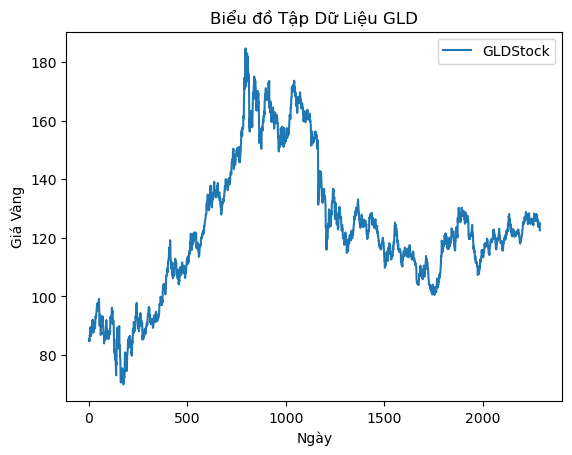

In [16]:
plt.title("Biểu đồ Tập Dữ Liệu "+nameData)
plt.plot(readData(filePath), label= nameData+'Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Vàng")
plt.legend()
plt.show()

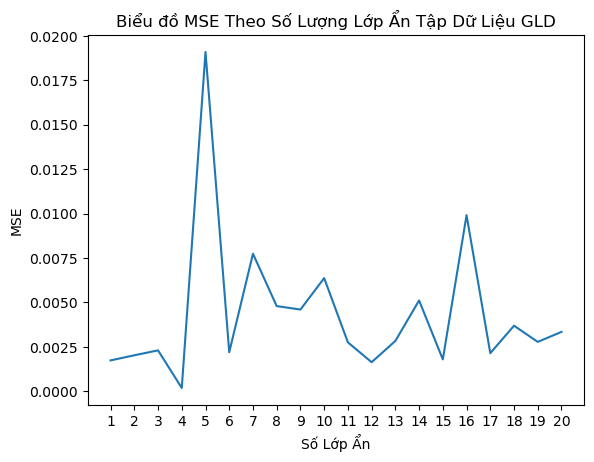

In [ ]:
# Vẽ biểu đồ
plt.plot(range(1,len(df_MseWith_HiddenLayer[['MSE']])+1), df_MseWith_HiddenLayer[['MSE']])
plt.title("Biểu đồ MSE Theo Số Lượng Lớp Ẩn Tập Dữ Liệu "+nameData)
plt.xlabel("Số Lớp Ẩn")
plt.ylabel("MSE")
plt.xticks(range(1,len(df_MseWith_HiddenLayer[['MSE']])+1))
plt.show()

In [25]:
df_MseWith_HiddenLayer_Sort = df_MseWith_HiddenLayer.sort_values('MSE')
best_NumberHiddenLayer=df_MseWith_HiddenLayer_Sort['Number Hidden Layer'].iloc[0]

In [19]:
df_MseWith_HiddenLayer_Sort

,Number Hidden Layer,Neural Hidden,Batch Size,Epoch,MSE,Time Train,Time Test,Total Time
3,4,13,32,200,0.000185,12.897301,1.575166,14.472467
11,12,13,32,200,0.001636,33.503182,4.938124,38.441306
0,1,13,32,200,0.001737,7.152045,0.644665,7.796710
14,15,13,32,200,0.001794,43.089109,7.612025,50.701135
1,2,13,32,200,0.002025,9.205762,1.505468,10.711230
16,17,13,32,200,0.002143,48.208651,7.907503,56.116154
5,6,13,32,200,0.002198,18.792742,2.976082,21.768824
2,3,13,32,200,0.002302,9.166702,1.518646,10.685348
10,11,13,32,200,0.002753,30.544434,5.084806,35.629240
18,19,13,32,200,0.002779,62.125652,8.439960,70.565612


In [26]:
best_NumberHiddenLayer

4

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step


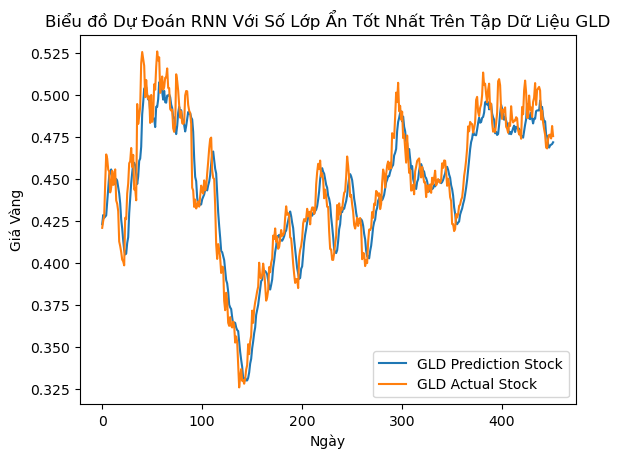

In [36]:
# Vẽ biểu đồ
best_param = {
    'batch_size': int(df_MseWith_HiddenLayer_Sort['Batch Size'].iloc[0]),
    'epochs': int(df_MseWith_HiddenLayer_Sort['Epoch'].iloc[0]),
    'neuralHidden': int(df_MseWith_HiddenLayer_Sort['Neural Hidden'].iloc[0]),
    'num_layers_hidden': int(df_MseWith_HiddenLayer_Sort['Number Hidden Layer'].iloc[0]),
    'neuralInput': size_window,
    'neuralOutput': size_predict,
    'activation': 'relu',  # Set a default value, like 'relu'
    'optimizer': 'adam'    # Set a default value, like 'adam'
}

y_pred= predict_RNN(nameData, 'RNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)

plt.title("Biểu đồ Dự Đoán RNN Với Số Lớp Ẩn Tốt Nhất Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Vàng")
plt.legend()
plt.show()

In [ ]:
    print("MSE: " + str(mean_squared_error(y_test , y_pred)))
    print("RMSE: " + str(sqrt(mean_squared_error(y_test, y_pred)) ))
    print("MAE: " + str(mean_absolute_error(y_test,y_pred)))
    print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred)))

MSE: 0.00018543972291093733
RMSE: 0.013617625450530548
MAE: 0.010612043800578043
MAPE: 0.023907507073021386


In [38]:
neural=13
batch_size=32
epochs=200

nameData= 'GLD'
filePath= '../data/'+nameData+'.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)
percentTrain = 80
train_data, test_data = splitData(timeSeries, percentTrain)

size_window = 5
size_predict=1
stepWindow=1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

numHiddenLayer= range(1,21)

df_MseWith_HiddenLayer = pd.DataFrame([],  columns =  ["Number Hidden Layer","Neural Hidden","Batch_Size","Epoch", "MSE"])

for i in range(len(numHiddenLayer)):

    best_param = {'batch_size': batch_size,
              'epochs': epochs,
              'neuralHidden': neural,
              'num_layers_hidden' : numHiddenLayer[i],
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
    y_pred= predict_FFNN(nameData, 'FFNN_Find_NumberHiddenLayer', X_train, y_train, X_test, best_param)
    rowMseWithHiddenLayer = pd.DataFrame([[numHiddenLayer[i],neural,batch_size,epochs, mean_squared_error(y_test , y_pred)]], columns=df_MseWith_HiddenLayer.columns)
    df_MseWith_HiddenLayer = pd.concat([df_MseWith_HiddenLayer,rowMseWithHiddenLayer],ignore_index=True)
df_MseWith_HiddenLayer_Sort = df_MseWith_HiddenLayer.sort_values('MSE')
best_Neural=df_MseWith_HiddenLayer_Sort['Number Hidden Layer'].iloc[0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
